In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Conv2D, ZeroPadding2D, Flatten, Dense, Activation, Add, BatchNormalization, MaxPool2D 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam

In [3]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    mapping = data["mapping"]
    return X, y, mapping

In [24]:
json_path = "../input/data-json/data_10.json"
X, y, mapping = load_data(json_path)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [27]:
X_train.shape

(6740, 130, 13)

In [28]:
X_train = np.expand_dims(X_train, -1)
X_test = X_test[..., np.newaxis]
X_val = np.expand_dims(X_val, -1)

In [29]:
def NiN_block(num_channels, kernel_size, padding, strides):
    return Sequential([
        Conv2D(num_channels, kernel_size, padding=padding, strides=strides, activation='relu'),
        Conv2D(num_channels, kernel_size=1, activation='relu'),
        Conv2D(num_channels, kernel_size=1, activation='relu')
    ])

In [30]:
def NiN_net(input_shape):
    network = Sequential([
        Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        NiN_block(128, kernel_size=3, strides=2, padding='same'),
        MaxPool2D(pool_size=2, strides=2),
        NiN_block(256, kernel_size=5, strides=1, padding='same'),
        MaxPool2D(pool_size=3, strides=2),
        GlobalAveragePooling2D(),
        Dense(10, activation='softmax')])
    return network

In [31]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.5e-3
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 35:
        lr *= 1e-1
    return lr
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  

In [32]:
model = NiN_net(X_train[0].shape)
optimizer = K.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 130, 13, 64)       640       
_________________________________________________________________
sequential_14 (Sequential)   (None, 65, 7, 128)        106880    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 3, 128)        0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 32, 3, 256)        951040    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 1, 256)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)              

In [33]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=40, callbacks=[lrdecay])

Epoch 1/40
106/106 [==============================] - 2s 17ms/step - loss: 1.6387 - accuracy: 0.4074 - val_loss: 1.2912 - val_accuracy: 0.5140
Epoch 2/40
106/106 [==============================] - 2s 15ms/step - loss: 1.1632 - accuracy: 0.5861 - val_loss: 0.9690 - val_accuracy: 0.6449
Epoch 3/40
106/106 [==============================] - 2s 16ms/step - loss: 0.9422 - accuracy: 0.6613 - val_loss: 0.7798 - val_accuracy: 0.7116
Epoch 4/40
106/106 [==============================] - 2s 16ms/step - loss: 0.7864 - accuracy: 0.7212 - val_loss: 0.7998 - val_accuracy: 0.7103
Epoch 5/40
106/106 [==============================] - 2s 16ms/step - loss: 0.6835 - accuracy: 0.7593 - val_loss: 0.6118 - val_accuracy: 0.7770
Epoch 6/40
106/106 [==============================] - 2s 16ms/step - loss: 0.5215 - accuracy: 0.8132 - val_loss: 0.5041 - val_accuracy: 0.8211
Epoch 7/40
106/106 [==============================] - 2s 16ms/step - loss: 0.4454 - accuracy: 0.8389 - val_loss: 0.5084 - val_accuracy: 0.8184

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test loss : {}, Test accuracy: {}".format(test_loss, test_acc))

79/79 [==============================] - 0s 4ms/step - loss: 0.3684 - accuracy: 0.8839
Test loss : 0.36844322085380554, Test accuracy: 0.8838606476783752


In [35]:
def plot_history(history): 
    fig, axs = plt.subplots(2, figsize=(10, 10))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="valid accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train loss")
    axs[1].plot(history.history["val_loss"], label="valid loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Valid evaluation")

    plt.show()

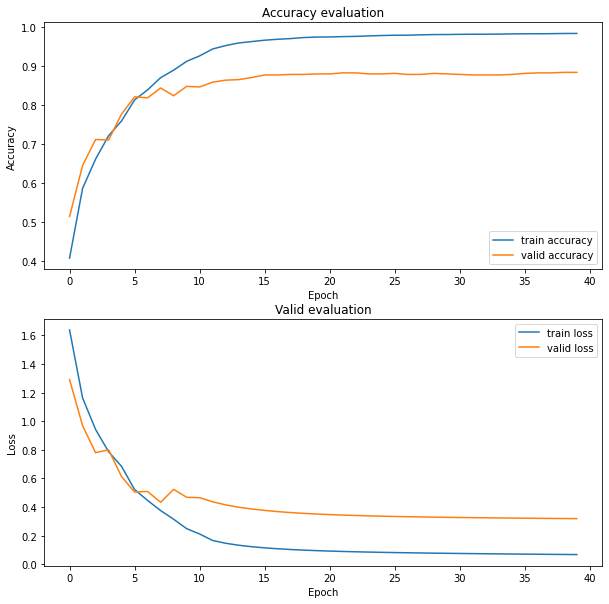

In [36]:
plot_history(history)